# Automated Evaluation

## Load Batch Inference Results

In [7]:
from pathlib import Path
from typing_extensions import TypedDict
import json

class InferenceItem(TypedDict):
    model: str
    neutral: str
    output: str
    character: str

BATCH_INFERENCE_FILE = Path("./outputs/batch_run_result.jsonl")

batch_inference_items: list[InferenceItem] = []

with open(BATCH_INFERENCE_FILE, "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        item:InferenceItem = json.loads(line.strip())

        item["output"] = item["output"].split("</think>")[1].strip() if "</think>" in item["output"] else item["output"]

        batch_inference_items.append(item)

## Style Consistency Evaluation

### Load Model

In [ ]:
from pathlib import Path
from typing import Tuple, Dict, List
from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from tokenizers import Tokenizer

import numpy as np
import torch.nn as nn
import torch
import os

BACKBONE_PATH = str(Path('../Models/chinese-roberta-wwm-ext').resolve())
CHECKPOINT_PATH = Path('outputs/style-classifier')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model definition
class CharacterStyleClassifier(nn.Module):
    def __init__(self, backbone_name: str, embed_dim: int = 768, proj_dim: int = 256, num_roles: int = 6, dropout: float = 0.4):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(backbone_name, output_hidden_states=False)
        self.hidden_size = self.backbone.config.hidden_size
        assert self.hidden_size == embed_dim, f"Backbone hidden_size {self.hidden_size} != embed_dim {embed_dim}"

        self.proj = nn.Sequential(
            nn.Linear(self.hidden_size, proj_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Linear(proj_dim, num_roles)

    def mean_pooling(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_hidden = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
        mean_pooled = sum_hidden / sum_mask
        return mean_pooled

    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        last_hidden = out.last_hidden_state
        sent_emb = self.mean_pooling(last_hidden, attention_mask)
        proj = self.proj(sent_emb)
        logits = self.classifier(proj)
        return logits, proj
    
def load_checkpoint(path: str, device='cpu') -> Tuple[nn.Module, 'Tokenizer', LabelEncoder, Dict[str, np.ndarray]]:
    tokenizer = AutoTokenizer.from_pretrained(path)
    with open(os.path.join(path, 'label_encoder.json'), 'r', encoding='utf-8') as f:
        le_json = json.load(f)
    le = LabelEncoder()
    le.classes_ = np.array(le_json['classes'])

    # use the saved backbone
    # 1. 从 config 获取 hidden_size
    backbone_hidden = AutoModel.from_pretrained(path).config.hidden_size
    # 2. 直接从 `path` 初始化模型，这将加载微调后的 backbone
    model = CharacterStyleClassifier(path, embed_dim=backbone_hidden, proj_dim=256, num_roles=len(le.classes_))
    # 3. 加载 head 权重
    chk = torch.load(os.path.join(path, 'head.pt'), map_location=device)
    model.proj.load_state_dict(chk['proj_state'])
    model.classifier.load_state_dict(chk['classifier_state'])
    # 4. 加载 centers
    centers_npz = np.load(os.path.join(path, 'role_centers.npz'))
    role_centers = {k: centers_npz[k] for k in centers_npz.files}
    return model.to(device), tokenizer, le, role_centers

@torch.no_grad()
def compute_role_centers(model: nn.Module, dataloader: DataLoader, label_encoder: LabelEncoder, device='cpu') -> Dict[str, np.ndarray]:
    model.eval()
    accum: Dict[int, List[np.ndarray]] = {}
    for batch in tqdm(dataloader, desc="Computing centers"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].cpu().numpy()
        _, embeddings = model(input_ids=input_ids, attention_mask=attention_mask)
        emb_np = embeddings.detach().cpu().numpy()
        for lbl, e in zip(labels, emb_np):
            accum.setdefault(int(lbl), []).append(e)
    role_centers = {}
    for lbl, vecs in accum.items():
        avg = np.mean(np.stack(vecs, axis=0), axis=0)
        role_name = label_encoder.inverse_transform([lbl])[0]
        role_centers[role_name] = avg
    return role_centers


def get_style_score(model: nn.Module, tokenizer, text: str, role_center: np.ndarray, device='cpu', max_length=128) -> float:
    model.eval()
    enc = tokenizer(text, truncation=True, max_length=max_length, padding='max_length', return_tensors='pt')
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)
    with torch.no_grad():
        _, emb = model(input_ids=input_ids, attention_mask=attention_mask)
        emb_np = emb.detach().cpu().numpy()[0]
    num = float(np.dot(emb_np, role_center))
    den = float(np.linalg.norm(emb_np) * np.linalg.norm(role_center) + 1e-9)
    return num / den

model, tokenizer, label_encoder, role_centers = load_checkpoint(str(CHECKPOINT_PATH), device)

### Execute Evaluation

In [8]:
import pandas as pd

# Calculate style scores for each item
results = []

for item in tqdm(batch_inference_items, desc="Evaluating Style"):
    character = item['character']
    output_text = item['output']
    
    if not character in role_centers:
        print(f"Warning: Character '{character}' not found in role centers. Skipping.")
        continue

    center = role_centers[character]
    score = get_style_score(model, tokenizer, output_text, center, device=device)
    
    results.append({
        **item,
        "style_score": score
    })
        

# Calculate average score per model
model_scores = {}
for res in results:
    m_name = res['model']
    if m_name not in model_scores:
        model_scores[m_name] = []
    model_scores[m_name].append(res['style_score'])

print("\nStyle Consistency Scores:")
for m_name, scores in model_scores.items():
    avg_score = np.mean(scores)
    print(f"Model: {m_name}, Average Style Score: {avg_score:.4f} (n={len(scores)})")

# Save detailed results
df_results = pd.DataFrame(results)

Evaluating Style: 100%|██████████| 5250/5250 [00:40<00:00, 129.34it/s]


Style Consistency Scores:
Model: Modelv1, Average Style Score: 0.5819 (n=750)
Model: Modelv2, Average Style Score: 0.5778 (n=750)
Model: BaselineA, Average Style Score: 0.8808 (n=750)
Model: BaselineB, Average Style Score: 0.7573 (n=750)
Model: BaselineC, Average Style Score: 0.6870 (n=750)
Model: Modelv2(inference-only), Average Style Score: 0.6271 (n=750)
Model: BaselineD, Average Style Score: 0.8740 (n=750)


## Semantic Preservation Evaluation

### Load Model

In [ ]:
from sentence_transformers import SentenceTransformer, util

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

MODEL_PATH = "../Models/bge-large-zh-v1.5"
semantic_model = SentenceTransformer(MODEL_PATH)

def compute_semantic_similarity(neutral_text, stylized_text):
    """
    计算两个句子的语义相似度 (0 ~ 1)
    """
    # BGE 建议在作为 Query 时添加指令，但作为对称相似度对比，直接编码通常效果已足够好
    # 或者是为两边都添加 "为这个句子生成表示以用于检索相关文章：" (视具体版本文档而定)
    # 对于 STS (Semantic Textual Similarity) 任务，v1.5 通常可以直接使用。
    
    embeddings = semantic_model.encode([neutral_text, stylized_text], normalize_embeddings=True)
    
    # 计算余弦相似度
    similarity = util.cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

### Execute Evaluation

In [ ]:
# Calculate semantic scores for each item
for item in tqdm(results, desc="Evaluating Semantic"):
    neutral_text = item['neutral']
    stylized_text = item['output']
    
    # Compute similarity
    score = compute_semantic_similarity(neutral_text, stylized_text)
    
    # Store result
    item['semantic_score'] = score

# === 计算 H-Score 与有效风格得分 ===
SEM_THRESHOLD = 0.80  # 语义门槛

for item in results:
    style_score = item.get('style_score', 0.0)
    sem_score = item.get('semantic_score', 0.0)
    
    # H-Score (harmonic mean)
    h_score = (2 * style_score * sem_score) / (style_score + sem_score + 1e-9)
    
    # 语义门控后的有效风格分
    penalty_factor = 1.0 if sem_score > SEM_THRESHOLD else 0.1
    penalized_style = style_score * penalty_factor
    
    item['h_score'] = h_score
    item['valid_style_score'] = penalized_style

# Aggregate results
model_metrics = {}

for item in results:
    m_name = item['model']
    char_name = item['character']
    sem = item['semantic_score']
    sty = item['style_score']
    h = item['h_score']
    vsty = item['valid_style_score']
    
    if m_name not in model_metrics:
        model_metrics[m_name] = {
            'semantic': [],
            'style': [],
            'h_score': [],
            'valid_style': [],
            'per_char': {}
        }
    
    # total
    model_metrics[m_name]['semantic'].append(sem)
    model_metrics[m_name]['style'].append(sty)
    model_metrics[m_name]['h_score'].append(h)
    model_metrics[m_name]['valid_style'].append(vsty)
    
    # per-character (只对语义分保留细粒度，若需要可以扩展)
    if char_name not in model_metrics[m_name]['per_char']:
        model_metrics[m_name]['per_char'][char_name] = []
    model_metrics[m_name]['per_char'][char_name].append(sem)

# Print Report
print(f"\nSemantic Preservation + Style Scores(SEM_THRESHOLD={SEM_THRESHOLD}):")
print("=" * 80)
for m_name, metrics in model_metrics.items():
    avg_sem = np.mean(metrics['semantic'])
    avg_style = np.mean(metrics['style'])
    avg_h = np.mean(metrics['h_score'])
    avg_vsty = np.mean(metrics['valid_style'])
    
    print(f"Model: {m_name}")
    sorted_chars = sorted(metrics['per_char'].keys())
    for char_name in sorted_chars:
        scores = metrics['per_char'][char_name]
        avg_char_sem = np.mean(scores)
        print(f"  - Character: {char_name:<10} | Sem: {avg_char_sem:.4f} (n={len(scores)})")
    
    print(f"  >> Avg Semantic: {avg_sem:.4f}")
    print(f"  >> Avg Style  : {avg_style:.4f}")
    print(f"  >> Avg H-Score: {avg_h:.4f}")
    print(f"  >> Avg Valid Style: {avg_vsty:.4f}")
    print("-" * 80)

# Update the DataFrame with the new scores
df_results = pd.DataFrame(results)

Evaluating Semantic: 100%|██████████| 5250/5250 [01:43<00:00, 50.78it/s]


Semantic Preservation + Style Scores(SEM_THRESHOLD=0.8):
Model: Modelv1
  - Character: 凉宫春日       | Sem: 0.8145 (n=150)
  - Character: 沐雪         | Sem: 0.8348 (n=150)
  - Character: 神里绫华       | Sem: 0.8323 (n=150)
  - Character: 胡桃         | Sem: 0.8428 (n=150)
  - Character: 钟离         | Sem: 0.8321 (n=150)
  >> Avg Semantic: 0.8313
  >> Avg Style  : 0.5819
  >> Avg H-Score: 0.6420
  >> Avg Valid Style: 0.4050
--------------------------------------------------------------------------------
Model: Modelv2
  - Character: 凉宫春日       | Sem: 0.8113 (n=150)
  - Character: 沐雪         | Sem: 0.8509 (n=150)
  - Character: 神里绫华       | Sem: 0.8328 (n=150)
  - Character: 胡桃         | Sem: 0.8391 (n=150)
  - Character: 钟离         | Sem: 0.8467 (n=150)
  >> Avg Semantic: 0.8361
  >> Avg Style  : 0.5778
  >> Avg H-Score: 0.6423
  >> Avg Valid Style: 0.4238
--------------------------------------------------------------------------------
Model: BaselineA
  - Character: 凉宫春日       | Sem: 0.5241 (n=

### Generate 2D Scatter Plot/Comprehensive Metrics Table

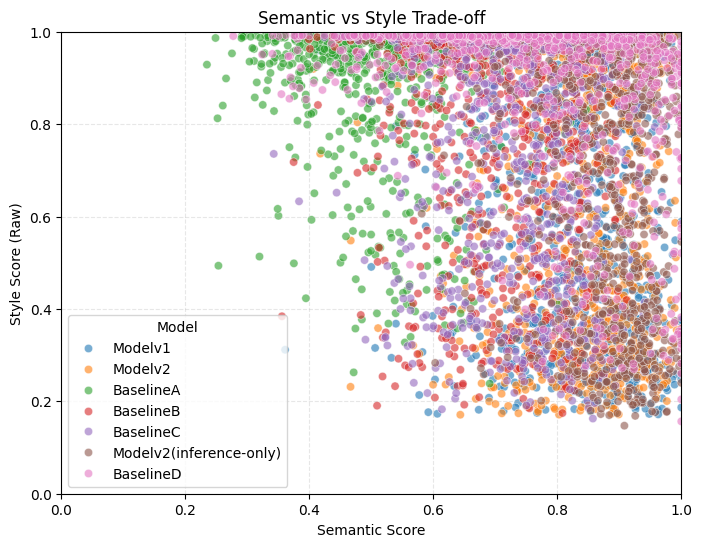

,model,semantic_score,style_score_raw,h_score,valid_style_score
5,Modelv2(inference-only),0.8783,0.6271,0.6915,0.5687
6,BaselineD,0.7681,0.8740,0.7871,0.5185
1,Modelv2,0.8361,0.5778,0.6423,0.4825
0,Modelv1,0.8313,0.5819,0.6420,0.4790
3,BaselineB,0.7148,0.7573,0.7088,0.3646
4,BaselineC,0.7374,0.6870,0.6796,0.3637
2,BaselineA,0.5081,0.8808,0.6288,0.1014


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 图表 3.1：二维散点图 (Semantic vs Style)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_results, x="semantic_score", y="style_score", hue="model", alpha=0.6)
plt.xlabel("Semantic Score")
plt.ylabel("Style Score (Raw)")
plt.title("Semantic vs Style Trade-off")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(title="Model")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# 表格 3.2：综合指标表 (Leaderboard)
leaderboard_rows = []
for m_name, metrics in model_metrics.items():
    semantic_score = round(np.mean(metrics["semantic"]), 4)
    style_score = round(np.mean(metrics["style"]), 4)
    h_score = round(np.mean(metrics["h_score"]), 4)
    valid_style_score = round(np.mean(metrics["valid_style"]), 4)
    leaderboard_rows.append({
        "model": m_name,
        "semantic_score": semantic_score,
        "style_score_raw": style_score,
        "h_score": h_score,
        "valid_style_score": valid_style_score,
    })

df_leaderboard = pd.DataFrame(leaderboard_rows).sort_values(by=["valid_style_score"], ascending=False)
df_leaderboard

### Export Evaluation Results

In [12]:
output_path = "./outputs/evaluate_result.jsonl"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(model_metrics, f, ensure_ascii=False, indent=4)

## LLM-as-a-Judge

### Define Model Service

In [ ]:
import os
from dataclasses import dataclass, field
from typing import Optional, Dict, Any, Sequence, Tuple, Iterable

from openai import OpenAI
from openai.types.chat import ChatCompletionMessageParam as ChatMsgParam
from dotenv import load_dotenv

load_dotenv()  # 从 .env 文件加载环境变量

# === 配置项 ===
DEFAULT_API_KEY = os.getenv("OPENAI_API_KEY", "sk-PLACEHOLDER")
DEFAULT_BASE_URL = os.getenv("OPENAI_BASE_URL", "https://dashscope.aliyuncs.com/compatible-mode/v1")
DEFAULT_MODEL = os.getenv("OPENAI_CHAT_MODEL", "qwen-plus-2025-09-11")

DEFAULT_SYSTEM_PROMPT = """你是一位资深的动漫角色扮演（Role-Playing）对话评估专家。你的任务是评估大语言模型生成的“风格化回复”的质量。
你需要对比“中性原句”和“生成的风格句”，并根据给定的“目标角色设定”，从三个维度(语义忠实度, 风格匹配度, 语言自然度)对生成结果进行打分（1-5分）和点评。

请注意：
1. 对于“Tsundere”或“sharp_tongued”类角色，有时出现的表面语义的否定（口是心非）是符合逻辑的，不应视为语义错误，只要底层的核心意图（如关心、接受）未丢失即可。
2. 对于“理性/沉稳”类角色，逻辑必须严密，不得出现轻浮的语气词（如“~”, “呀”, “喵”）。
3. 必须严厉惩罚“幻觉”（编造原句不存在的内容）和“OOC”（Out-Of-Character, 风格与角色不匹配/使用了不属于该角色的口癖）。

---

### 评估维度与标准

请基于以下三个维度进行评分（1-5分）：

#### 维度 1: 语义忠实度(semantic_faithfulness)
* **5分**: 完美保留了原句的核心意图。没有添加任何无关信息（幻觉）。
* **3分**: 保留了大部分意图，但添加了少量无关的细节，或丢失了部分次要信息。
* **1分**: 严重幻觉（胡言乱语），或者完全改变了原句的意思（例如将“喜欢”变成了真正的“厌恶”，而非傲娇的掩饰）。
* *注意： 部分模型输出会出现检索导致的幻觉，请重点检查是否出现了原句没有的名词或事件。*

#### 维度 2: 风格匹配度(style_logic)
* **5分**:
    * 对于**傲娇/毒舌或其他带有语义反转性格的角色**：成功实现了“语义反转”（心口不一），逻辑转换非常自然（例如：将“谢谢”转化为“哼，别以为我会感激你”）。
    * 对于**普通角色**：语气符合人设，逻辑通顺。
* **3分**: 尝试了风格转换，但逻辑生硬。例如：傲娇角色只是简单地在句首加了“哼”，但后面的句子依然直白（“哼，谢谢你”），导致割裂感。
* **1分**: 逻辑完全崩坏。例如：理性角色突然变得歇斯底里，或者傲娇角色直白地表达爱意（OOC）。

#### 维度 3: 语言自然度(idiolect_naturalness)
* **5分**: 口癖（如“喵”、“本王”）和语气词使用恰当且自然，融入了句子结构中。且语言通顺无语法错误。
* **3分**: 机械地堆砌关键词。例如：在句尾强行加“喵”，但前面的语调完全不像猫娘。语言整体流畅可读，无重大语法错误。
* **1分**: **严重 OOC (Out of Character)**。使用了错误的口癖（例如：钟离使用了波浪号“~”，或者神里绫华说了脏话），对此请特别注意部分输出可能出现的角色混淆问题。或语言结构不清晰，语法出现重大错误完全不可读

---

### 输出格式 (JSON)

请严格按照以下 JSON 格式输出评估结果：

```json
{{
  "reasoning": "在此处简要分析模型的表现，指出优点和具体的致命缺陷（如幻觉、OOC、逻辑割裂）。（50字以内）",
  "scores": {{
    "semantic_faithfulness": <int>,
    "style_logic": <int>,
    "idiolect_naturalness": <int>
  }}
}}

"""

prompt_template = """### 任务信息
**目标角色**: {character_name}
**角色性格/语用标签**: {pragmatic_styles}
**角色关键词/口癖**: {keywords}

### 输入数据
**【中性原句】**:
"{neutral_sentence}"

**【模型生成的风格句】**:
"{generated_sentence}"
"""

ConversationTurn = Tuple[str, Optional[str]]
"""表示一次对话轮次：(user_message, assistant_reply)。assistant_reply 可为 None。"""


def _build_messages(
    prompt: str,
    history: Optional[Sequence[ConversationTurn]] = None,
    system_prompt: Optional[str] = None,
) -> list[ChatMsgParam]:
    messages: list[ChatMsgParam] = []

    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})

    if history:
        for user_msg, assistant_msg in history:
            messages.append({"role": "user", "content": user_msg})
            if assistant_msg:
                messages.append({"role": "assistant", "content": assistant_msg})

    messages.append({"role": "user", "content": prompt})
    return messages


@dataclass(slots=True)
class SimpleLLMClient:
    """极简 LLM 封装：初始化固定模型，提供 ask() 返回字符串。"""

    model: str = DEFAULT_MODEL
    api_key: str = DEFAULT_API_KEY
    base_url: Optional[str] = DEFAULT_BASE_URL
    system_prompt: Optional[str] = DEFAULT_SYSTEM_PROMPT
    extra_headers: Optional[Dict[str, str]] = None
    _client: OpenAI = field(init=False, repr=False)

    def __post_init__(self) -> None:
        self._client = OpenAI(
            api_key=self.api_key,
            base_url=self.base_url,
            default_headers=self.extra_headers if self.extra_headers else None,
        )

    def _consume_stream(self, stream_resp: Iterable[Any]) -> str:
        """消费流式响应，拼接内容。"""
        chunks: list[str] = []
        for chunk in stream_resp:
            choices = getattr(chunk, "choices", None)
            if not choices:
                continue
            delta = getattr(choices[0], "delta", None)
            if delta and getattr(delta, "content", None):
                chunks.append(delta.content)
        return "".join(chunks)

    def ask(
        self,
        prompt: str,
        history: Optional[Sequence[ConversationTurn]] = None,
        *,
        temperature: float = 0.7,
        top_p: float = 0.9,
        max_tokens: Optional[int] = None,
        **kwargs: Any,
    ) -> str:
        """生成回复。

        参数：
            prompt: 当前用户输入。
            history: 可选的历史 [(user, assistant), ...]，assistant 允许为 None。
            temperature/max_tokens/stream/kwargs：直接透传给 OpenAI Chat Completion。
        返回：
            模型回复的纯文本（若响应为空则返回空字符串）。
        """
        messages = _build_messages(
            prompt=prompt,
            history=history,
            system_prompt=self.system_prompt,
        )

        response = self._client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p,
            stream=False,
            extra_body={"enable_thinking": False},
            **kwargs,
        )

        choice = response.choices[0]
        if hasattr(choice, "message") and getattr(choice.message, "content", None):
            return choice.message.content  # type: ignore[return-value]
        # 兼容历史版本/异常情况
        return getattr(choice, "text", "")


# 初始化一个通用实例，供 Notebook 其他单元直接调用
llm = SimpleLLMClient()

### Construct Character Style Vectors

In [16]:
from typing_extensions import TypedDict, Optional
from collections import Counter
from pathlib import Path

import json

Pragmatic_Muice = "./outputs/pragmatic/muice.jsonl"
Pragmatic_ayaka = "./outputs/pragmatic/ayaka.jsonl"
Pragmatic_zhongli = "./outputs/pragmatic/zhongli.jsonl"
Pragmatic_hutao = "./outputs/pragmatic/hutao.jsonl"
Pragmatic_haruhi = "./outputs/pragmatic/haruhi.jsonl"

class RawPCFGItem(TypedDict):
    prompt: str
    response: str
    pragmatic_styles: list[dict[str, float]]

class PCFGItem(TypedDict):
    response: str
    pragmatic_styles: list[str]

def read_pcfg_jsonl_file(jsonl_file: Path, threshold: Optional[float] = None, top_n: int = 5) -> list[str]:
    with open(jsonl_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    raw_items: list[RawPCFGItem] = []
    items: list[str] = []

    for line in lines:
        if line := line.strip():
            raw_item: RawPCFGItem = json.loads(line)
            raw_items.append(raw_item)

    # list[dict[str, float]] -> dict[str, float] -> list[str]
    for raw_item in raw_items:
        raw_pragmatic_styles = raw_item["pragmatic_styles"]
        pragmatic_styles: dict[str, float] = {}

        for vec in raw_pragmatic_styles:
            pragmatic_styles.update(vec)

        threshold = threshold or 0
        final_styles: list[str] = []

        for key, value in pragmatic_styles.items():
            if value > threshold:
                final_styles.append(key)
        
        items.extend(final_styles)

    # 返回 Top N 风格
    style_counter = Counter(items)
    most_common_styles = [style for style, _ in style_counter.most_common(top_n)]

    return most_common_styles

pcfg_muice_items = read_pcfg_jsonl_file(Path(Pragmatic_Muice), 0.4)
pcfg_ayaka_items = read_pcfg_jsonl_file(Path(Pragmatic_ayaka), 0.4)
pcfg_zhongli_items = read_pcfg_jsonl_file(Path(Pragmatic_zhongli), 0.4)
pcfg_hutao_items = read_pcfg_jsonl_file(Path(Pragmatic_hutao), 0.4)
pcfg_haruhi_items = read_pcfg_jsonl_file(Path(Pragmatic_haruhi), 0.4)


In [17]:
from dataclasses import dataclass

@dataclass
class CharacterProfile:
    name: str
    syntactic_vec: dict[str, float]
    pragmatic_styles: list[str]
    lexical_keywords: list[str]

muice_profile = CharacterProfile(name="沐雪",
                                syntactic_vec={
                                    'declarativity': 0.1103257643217572,
                                    'parallelism': 0.02918150786583556,
                                    'ellipsis_or_fragmentation': 0.08529979222321163,
                                    'subordination': 0.19688705847432472,
                                    'interjectionality': 0.008644998515880083,
                                    'clausal_embedding': 0.034784060552092606,
                                    'referentiality': 0.11624369249035323,
                                    'syntactic_compression': 0.18596022558622738,
                                    'nominal_complexity': 0.03342980112793114,
                                    'coordination_density': 0.002615761353517364,
                                    'quantificationality': 0.038197536360937964,
                                    'modifier_density': 0.1393217571979816,
                                    'prepositional_density': 0.01910804392994954
                                    },
                                pragmatic_styles=pcfg_muice_items,
                                lexical_keywords=["喵", "沐沐", "AI", "恼", "沐雪", "女孩子", "~", "⭐", "不行", "聊天", "呀", "可爱", "才", "叫", "唔", "谁", "不会", "吃", "睡觉", "笨蛋", "答", "谢谢", "把", "即", "吧"]
                                )


ayaka_profile = CharacterProfile(name="神里绫华",
                                 syntactic_vec={
                                    "declarativity": 0.09320164543629895,
                                    "parallelism": 0.029192583613203236,
                                    "ellipsis_or_fragmentation": 0.061485264601259915,
                                    "subordination": 0.18419745235587529,
                                    "clausal_embedding": 0.046163629498618866,
                                    "interjectionality": 0.002046859164166054,
                                    "syntactic_compression": 0.1999165358399078,
                                    "nominal_complexity": 0.05623894596689255,
                                    "referentiality": 0.10019673694878878,
                                    "coordination_density": 0.02416486158860118,
                                    "quantificationality": 0.042964170028417556,
                                    "modifier_density": 0.13753701238051708,
                                    "prepositional_density": 0.022694302577452752
                                },
                                pragmatic_styles=pcfg_ayaka_items,
                                lexical_keywords=["稻妻国", "神里家", "稻妻", "大小姐", "家族", "传统", "奉行", "文化", "人民", "眼狩令", "神", "当地", "社", "舞蹈", "美丽", "茶道", "神社", "祭典", "眼", "美食", "继承", "剑术", "国家", "将军", "责任"],
                                )

zhongli_profile = CharacterProfile(name="钟离",
                                   syntactic_vec={
                                    "declarativity": 0.09879656160458453,
                                    "parallelism": 0.029398280802292263,
                                    "ellipsis_or_fragmentation": 0.06412607449856733,
                                    "subordination": 0.1839541547277937,
                                    "clausal_embedding": 0.037478510028653295,
                                    "interjectionality": 0.003151862464183381,
                                    "syntactic_compression": 0.21077363896848136,
                                    "quantificationality": 0.04022922636103152,
                                    "referentiality": 0.08240687679083095,
                                    "nominal_complexity": 0.06372492836676218,
                                    "coordination_density": 0.02332378223495702,
                                    "modifier_density": 0.14068767908309457,
                                    "prepositional_density": 0.02194842406876791
                                    },
                                    pragmatic_styles=pcfg_zhongli_items,
                                    lexical_keywords=['岩石', '岩', '璃月', '力', '璃', '契约', '炼金术', '月', '盐', '帝君', '魔神', '操控', '王', '并非', '岩王', '大地', '封印', '作战', '掌握', '大陆', '学问', '研究', '七星', '客卿', '岩元素'],
                                    )

hutao_profile = CharacterProfile(name="胡桃",
                                 syntactic_vec={
                                    "parallelism": 0.03191357258164659,
                                    "declarativity": 0.10471252949211474,
                                    "ellipsis_or_fragmentation": 0.07646218800447038,
                                    "clausal_embedding": 0.042685955544517575,
                                    "subordination": 0.18254066807400968,
                                    "interjectionality": 0.01809884515087545,
                                    "syntactic_compression": 0.1987458090152738,
                                    "referentiality": 0.09049422575437725,
                                    "quantificationality": 0.05016763938904756,
                                    "nominal_complexity": 0.034459207748665094,
                                    "coordination_density": 0.013845771762076246,
                                    "modifier_density": 0.1413448404321371,
                                    "prepositional_density": 0.014528747050788526
                                },
                                pragmatic_styles=pcfg_zhongli_items,
                                lexical_keywords=['往生堂', '嘿嘿', '嘻嘻', '可是', '堂主', '哎呀呀', '哦哦哦', '宝藏', '惊喜', '诗歌', '可不是', '灵魂', '胡桃', '神秘', '生死', '谜题', '哈哈哈', '不过', '有趣', '亡灵', '秘密', '意想不到', '巫师', '哇', '奇妙']
                                )

haruhi_profile = CharacterProfile(name="凉宫春日",
                                  syntactic_vec={
                                    "declarativity": 0.0939982347749338,
                                    "parallelism": 0.032288908502500734,
                                    "subordination": 0.19174757281553398,
                                    "ellipsis_or_fragmentation": 0.07542659605766402,
                                    "clausal_embedding": 0.042144748455428066,
                                    "interjectionality": 0.008017063842306561,
                                    "syntactic_compression": 0.18409826419535158,
                                    "quantificationality": 0.040453074433656956,
                                    "referentiality": 0.12099146807884673,
                                    "nominal_complexity": 0.043211238599588114,
                                    "coordination_density": 0.01195204471903501,
                                    "prepositional_density": 0.011253309796999117,
                                    "modifier_density": 0.14441747572815533
                                },
                                pragmatic_styles=pcfg_haruhi_items,
                                lexical_keywords=['团', 'SOS', '阿虚', '社团', '哼', '事件', '学校', '超自然', '朝比奈', '文化祭', '创意', '吸引', '古泉', '电影', '创新', '组织', '实玖瑠', '当然', '与众不同', '主题', '加入', '束缚', '凉宫', '团长', '外星人']
                                )

### Execute Evaluation

In [18]:
import json
import time
from tqdm import tqdm

# 建立角色名到 Profile 的映射
NAME_TO_PROFILE = {
    "沐雪": muice_profile,
    "神里绫华": ayaka_profile,
    "钟离": zhongli_profile,
    "胡桃": hutao_profile,
    "凉宫春日": haruhi_profile
}

def get_char_meta(name):
    """从 CharacterProfile 中提取元数据用于 Prompt 构建"""
    profile = NAME_TO_PROFILE.get(name)
    assert profile
    styles = ", ".join(profile.pragmatic_styles[:5])
    keywords = ", ".join(profile.lexical_keywords[:15])
    return {"styles": styles, "keywords": keywords}

def parse_llm_response(response: str) -> dict:
    """解析 LLM 返回的 JSON 字符串，支持 Markdown 代码块包裹的情况"""
    content = response.strip()
    
    # 尝试提取 ```json ... ``` 块
    if "```json" in content:
        content = content.split("```json")[1].split("```")[0].strip()
    elif "```" in content: 
        content = content.split("```")[1].strip()
        
    # 寻找最外层的 {}
    start_idx = content.find("{")
    end_idx = content.rfind("}")
    
    if start_idx != -1 and end_idx != -1:
        json_str = content[start_idx:end_idx+1]
        try:
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            raise ValueError(f"Invalid JSON format: {e}")
    else:
        raise ValueError(f"No JSON structure found in response: {response[:50]}...")

llm_eval_results = []
START_INDEX = 4500  # 从上次断点处恢复推理，如必要请调整至 0.
MAX_RETRIES = 3

for item in tqdm(batch_inference_items[START_INDEX:], desc="LLM Judging"):
    char_name = item['character']
    meta = get_char_meta(char_name)
    
    # 1. 构造 Prompt
    prompt = prompt_template.format(
        character_name=char_name,
        pragmatic_styles=meta["styles"],
        keywords=meta["keywords"],
        neutral_sentence=item['neutral'],
        generated_sentence=item['output']
    )
    
    success = False
    last_error = None
    
    for attempt in range(MAX_RETRIES):
        try:
            # 2. 调用 LLM
            response = llm.ask(prompt)
            
            # 3. 解析 JSON
            eval_res = parse_llm_response(response)
            scores = eval_res.get("scores", {})
            
            # 4. 存储结果
            llm_eval_results.append({
                **item,
                "llm_reasoning": eval_res.get("reasoning", ""),
                "score_semantic": float(scores.get("semantic_faithfulness", 0)),
                "score_style_logic": float(scores.get("style_logic", 0)),
                "score_naturalness": float(scores.get("idiolect_naturalness", 0))
            })
            success = True
            break # 成功则跳出重试循环
            
        except Exception as e:
            last_error = e
            # 失败则等待后重试
            if attempt < MAX_RETRIES - 1:
                time.sleep(1)
    
    if not success:
        print(f"Skipping item (Model: {item['model']}, Char: {char_name}) after {MAX_RETRIES} retries. Error: {last_error}")
        # 记录失败条目，分数为 0
        llm_eval_results.append({
            **item,
            "llm_reasoning": f"Error after {MAX_RETRIES} retries: {str(last_error)}",
            "score_semantic": 0.0,
            "score_style_logic": 0.0,
            "score_naturalness": 0.0
        })

LLM Judging: 100%|██████████| 750/750 [22:01<00:00,  1.76s/it]


In [19]:
# 5. 汇总分析
import pandas as pd

df_llm = pd.DataFrame(llm_eval_results)

# 保存详细结果
output_file = "./outputs/llm_evaluation_detailed.jsonl"
with open(output_file, "a", encoding="utf-8") as f:
    df_llm.to_json(
        f,
        orient="records",
        lines=True,
        force_ascii=False
    )
print(f"\nDetailed results saved to {output_file}")




Detailed results saved to ./evaluate/outputs/llm_evaluation_detailed.jsonl


In [20]:
import pandas as pd

output_file = "./outputs/llm_evaluation_detailed.jsonl"
df_llm = pd.read_json(output_file, lines=True)


print("\n=== LLM Evaluation Report ===")
# 按模型计算平均分
summary = df_llm.groupby("model")[["score_semantic", "score_style_logic", "score_naturalness"]].mean()
print(summary)


=== LLM Evaluation Report ===
                         score_semantic  score_style_logic  score_naturalness
model                                                                        
BaselineA                      3.316000           2.898667           2.508000
BaselineB                      3.756000           2.197333           1.934667
BaselineC                      3.426667           2.188000           1.941333
BaselineD                      4.092667           4.054667           4.186000
Modelv1                        4.089333           2.812000           2.789333
Modelv2                        4.449333           2.597333           2.470667
Modelv2(inference-only)        4.596000           2.406667           2.164000
